# GBM Simulation for Stocks

## Project Summary

This project simulates **Geometric Brownian Motion (GBM)** to model and forecast future stock prices for top technology tickers. It combines:
- **Quantitative finance mathematics** (GBM stochastic differential equations)
- **Data science** (log returns, drift, volatility estimation)
- **Real market data** from Yahoo Finance

I aim to understand both the **stochastic components (Brownian motion increments)** and the **drift component** that drive daily returns, then use these to simulate future prices over both long-term (quarterly horizon) and intraday (hourly interval).

### Mathematical Background

#### Geometric Brownian Motion (GBM)
The stock price under GBM evolves according to:

$$
dS_t = \mu S_t dt + \sigma S_t dB_t
$$

where:
- $\mu$ is the **drift** (expected return)  
- $\sigma$ is the **volatility** (standard deviation of returns)  
- $B_t$ is a **standard Brownian motion**

The discretized solution is:

$$
S_t = S_0 \exp \left[ (\mu - \frac{1}{2}\sigma^2)t + \sigma B_t \right]
$$


#### Stochastic Differential Equation (SDE)
The GBM SDE indicates that the instantaneous change in the stock price $dS_t$ is composed of a **deterministic trend** ($\mu S_t dt$) and a **random shock** ($\sigma S_t dB_t$), which defined is:

$$
dS_t = \mu S_t dt + \sigma S_t dB_t
$$

where:
- $dB_t$ is an increment of a **standard Brownian motion**, representing the stochastic (random) component.


#### Log Return Distribution under GBM
Under GBM assumptions, the **log return** over time horizon $t$ is normally distributed:

$$
r_t = \log S_t \sim \mathcal{N} \left( \log S_0 + \left( \mu - \frac{1}{2} \sigma^2 \right)t , \sigma^2 t \right)
$$

or equivalently,

$$
\log \left( \frac{S_t}{S_0} \right) \sim \mathcal{N} \left( \left( \mu - \frac{1}{2} \sigma^2 \right)t , \sigma^2 t \right)
$$

where:

- $r_t$ is the **log price at time $t$**  
- The mean is adjusted by $\left( \mu - \frac{1}{2} \sigma^2 \right)t$ due to **Ito’s lemma correction** (accounting for volatility drag)
- The variance grows linearly with time: $\sigma^2 t$


#### Interpretation

- **GBM (Geometric Brownian Motion)** is a continuous-time stochastic process used to model stock prices, assuming proportional random changes and lognormal distribution of prices. 
- **SDE** captures the continuous-time dynamics of stock prices, combining trend and randomness.  
- **Log Return Distribution** is useful for deriving option pricing models (e.g. Black-Scholes) and simulating future prices via Monte Carlo.  
- **Volatility drag adjustment ($-\frac{1}{2}\sigma^2$)** reflects the fact that geometric returns are lognormally distributed, and higher volatility reduces expected geometric growth rate.


### Code Workflow

1. **Download** 1-year daily close prices from Yahoo Finance using `yfinance`.
2. **Calculate daily log returns** to derive the mean (drift) and standard deviation (volatility).
3. **Annualize** drift and volatility to fit the GBM parameters.
4. **Generate Brownian motion increments and path**:
   - `brownian_increments = np.random.normal(0, sqrt(dt), N)`
   - `brownian_path = np.concatenate([0], np.cumsum(brownian_increments))`
5. **Compute GBM path** over the selected time window (T).
6. **Plot simulated GBM paths** for selected tickers under two modes:
   - Quarterly (63 trading days) – for long-term trend analysis
   - Hourly (7 hours within a trading day) – for intraday price simulation

### Key Observations

- **Brownian increments** determine the random shocks (stochastic component) of daily returns.  
- **Brownian path** accumulates these shocks, visualizing the deviation from the deterministic drift.  
- The final GBM path combines drift + stochastic components to model potential future prices.

### Sample Outputs

1. **First 5 Brownian increments** printed for insight into daily random shocks  
2. **Final Brownian path value** printed for cumulative random impact

### GBM Simulation Plots

Below are the GBM simulation results for **QQQ and its top 5 constituents** (MSFT, AAPL, META, GOOGL, TSLA):
   - Quarterly mode: Simulates stock prices over ~63 trading days
   - Hourly mode: Simulates price movements within the next trading day (7 × 30-min steps)

### Simulation Modes

This project supports two modes of simulation:
   - Quarterly: simulates long-term evolution of stock prices over a 3-month horizon
   - Hourly: simulates intraday price movements across 7 half-hour intervals, useful for short-term trading strategies




In [4]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

"""
Period for GBM simulation can be 'quarterly' or 'hourly'.
1. Window: After 3 months => 'period': '2y', 'interval': '1d','scaling_factor': 252, 'T': 0.25, 'N': 63
2. Window: After 1 month => 'period': '1y', 'interval': '1d', 'scaling_factor': 252, 'T': 1/12, 'N': 21
3. Window: After 1 day(hourly) => 'period': '60d', 'interval': '60m', 'scaling_factor': 7, 'T': 1, 'N': 7
4. Window: After 1 day(30 minute) => 'period': '60d', 'interval': '30m', 'scaling_factor': 14, 'T': 1, 'N': 14
5. New company stocks(less than 2 years) => Using all available data for the stock after listing date(IPO date)
"""
def simulate_gbm(ticker_symbol, mode='quarterly'):
    # Set parameters according to mode
    if mode == 'quarterly':
        params = {
            'period': '2y',         # 2 years of data
            'interval': '1d',       # Daily data for 2 years
            'scaling_factor': 252,  # Trading days per year
            'T': 0.25,              # 0.25 years (1 quarter)
            'N': 63,                # 63 trading days
            'xlabel': 'Trading Day'
        }
    elif mode == 'hourly':
        params = {
            'period': '60d',
            'interval': '30m',
            'scaling_factor': 14,   # 30 minute intervals for 7 trading hours
            'T': 1,                 # 1 day
            'N': 14,                # 14 intervals (30 minutes each)
            'xlabel': 'Trading Hour of the Day'
        }
    else:
        raise ValueError("Invalid mode. Choose 'quarterly' or 'hourly'.")

    # Download market data
    stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
    
    if stock.empty or len(stock) < 2:
        print(f"Warning: Not enough {mode} data for {ticker_symbol} to simulate.")
        return None

    # Calculate log returns and compute parameters
    stock['LogReturn'] = np.log(stock['Close'] / stock['Close'].shift(1))
    stock = stock.dropna()
    
    mu = stock['LogReturn'].mean() * params['scaling_factor']
    sigma = stock['LogReturn'].std() * np.sqrt(params['scaling_factor'])
    S0 = stock['Close'].iloc[-1].item()
    dt = params['T'] / params['N']

    # Compute GBM path (vectorized method)
    brownian_increments = np.random.normal(0, np.sqrt(dt), params['N'])
    brownian_path = np.concatenate(([0], np.cumsum(brownian_increments)))
    time_grid = np.linspace(0, params['T'], params['N'] + 1)
    gbm_path = S0 * np.exp((mu - 0.5 * sigma**2) * time_grid + sigma * brownian_path)
    
    # Grid for x-axis (for display in trading days or hours)
    display_grid = np.arange(params['N'] + 1)
    
    return {
        'grid': display_grid,
        'path': gbm_path,
        's0': S0,
        'xlabel': params['xlabel'],
        'title': f'{mode.capitalize()} Simulation for {ticker_symbol}'
    }


def rank_stocks_by_gbm(tickers, mode='quarterly'):
    results_list = []

    for ticker in tickers:
        results = simulate_gbm(ticker, mode=mode)
        
        if results:
            gbm_path = results['path']
            s0 = results['s0']
            
            # Calculate the average value of the simulated GBM path
            path_avg = np.mean(gbm_path)
            
            # Compute a normalized score (expected average return)
            normalized_score = (path_avg - s0) / s0
            
            results_list.append({'ticker': ticker, 'score': normalized_score})

    # Sort the list by score in descending order
    sorted_results = sorted(results_list, key=lambda x: x['score'], reverse=True)

    # Print ranking results
    print(f"\nRanking stocks based on {mode} GBM simulation: ")
    for i, result in enumerate(sorted_results):
        print(f"Rank {i+1}: {result['ticker']:<6} | Score: {result['score']:.4f}")
    
    return sorted_results


def plot_gbm_simulations(tickers, mode='quarterly'):
    print(f"Target tickers for {mode} analysis: {tickers}")

    num_tickers = len(tickers)
    if num_tickers == 0:
        print("No tickers to plot.")
        return

    # Calculate the number of rows and columns for subplots
    ncols = 3
    nrows = (num_tickers + ncols - 1) // ncols

    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    
    main_title = 'Hourly GBM Simulation for Next Trading Day' if mode == 'hourly' else 'GBM Simulation for Next Quarter'
    fig.suptitle(main_title, fontsize=16)
    axes = axes.flatten()

    for i, ticker_symbol in enumerate(tickers):
        ax = axes[i]
        
        results = simulate_gbm(ticker_symbol, mode=mode)
        
        if results:
            ax.plot(results['grid'], results['path'], label='Simulated Path')
            ax.axhline(y=results['s0'], color='r', linestyle='--', label=f"Start Price: ${results['s0']:.2f}")
            ax.set_title(results['title'])
            ax.set_xlabel(results['xlabel'])
            ax.set_ylabel("Stock Price")
            ax.grid(True)
            ax.legend()
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Ranking stocks based on quarterly GBM simulation: 
Rank 1: IREN   | Score: 1.1556
Rank 2: PLTR   | Score: 0.3697
Rank 3: NVDA   | Score: 0.3691
Rank 4: SMCI   | Score: 0.3667
Rank 5: SOFI   | Score: 0.2157
Rank 6: MRNA   | Score: 0.2004
Rank 7: TSM    | Score: 0.1107
Rank 8: GOOGL  | Score: 0.0827
Rank 9: QQQ    | Score: 0.0820
Rank 10: MSFT   | Score: 0.0713
Rank 11: ORCL   | Score: 0.0624
Rank 12: META   | Score: 0.0115
Rank 13: NFLX   | Score: 0.0091
Rank 14: PFE    | Score: -0.0116
Rank 15: UBER   | Score: -0.0120
Rank 16: AAPL   | Score: -0.0243
Rank 17: AMZN   | Score: -0.0399
Rank 18: RKLB   | Score: -0.0688
Rank 19: JNJ    | Score: -0.0703
Rank 20: IONQ   | Score: -0.0813
Rank 21: SMR    | Score: -0.0985
Rank 22: TSLA   | Score: -0.1002
Rank 23: LYFT   | Score: -0.1087
Rank 24: AMD    | Score: -0.1188
Target tickers for quarterly analysis: ['QQQ', 'TSLA', 'MSFT', 'AAPL', 'META', 'GOOGL', 'AMZN', 'NVDA', 'NFLX', 'AMD', 'ORCL', 'UBER', 'LYFT', 'SMCI', 'IONQ', 'PLTR', 'IREN', 'RK

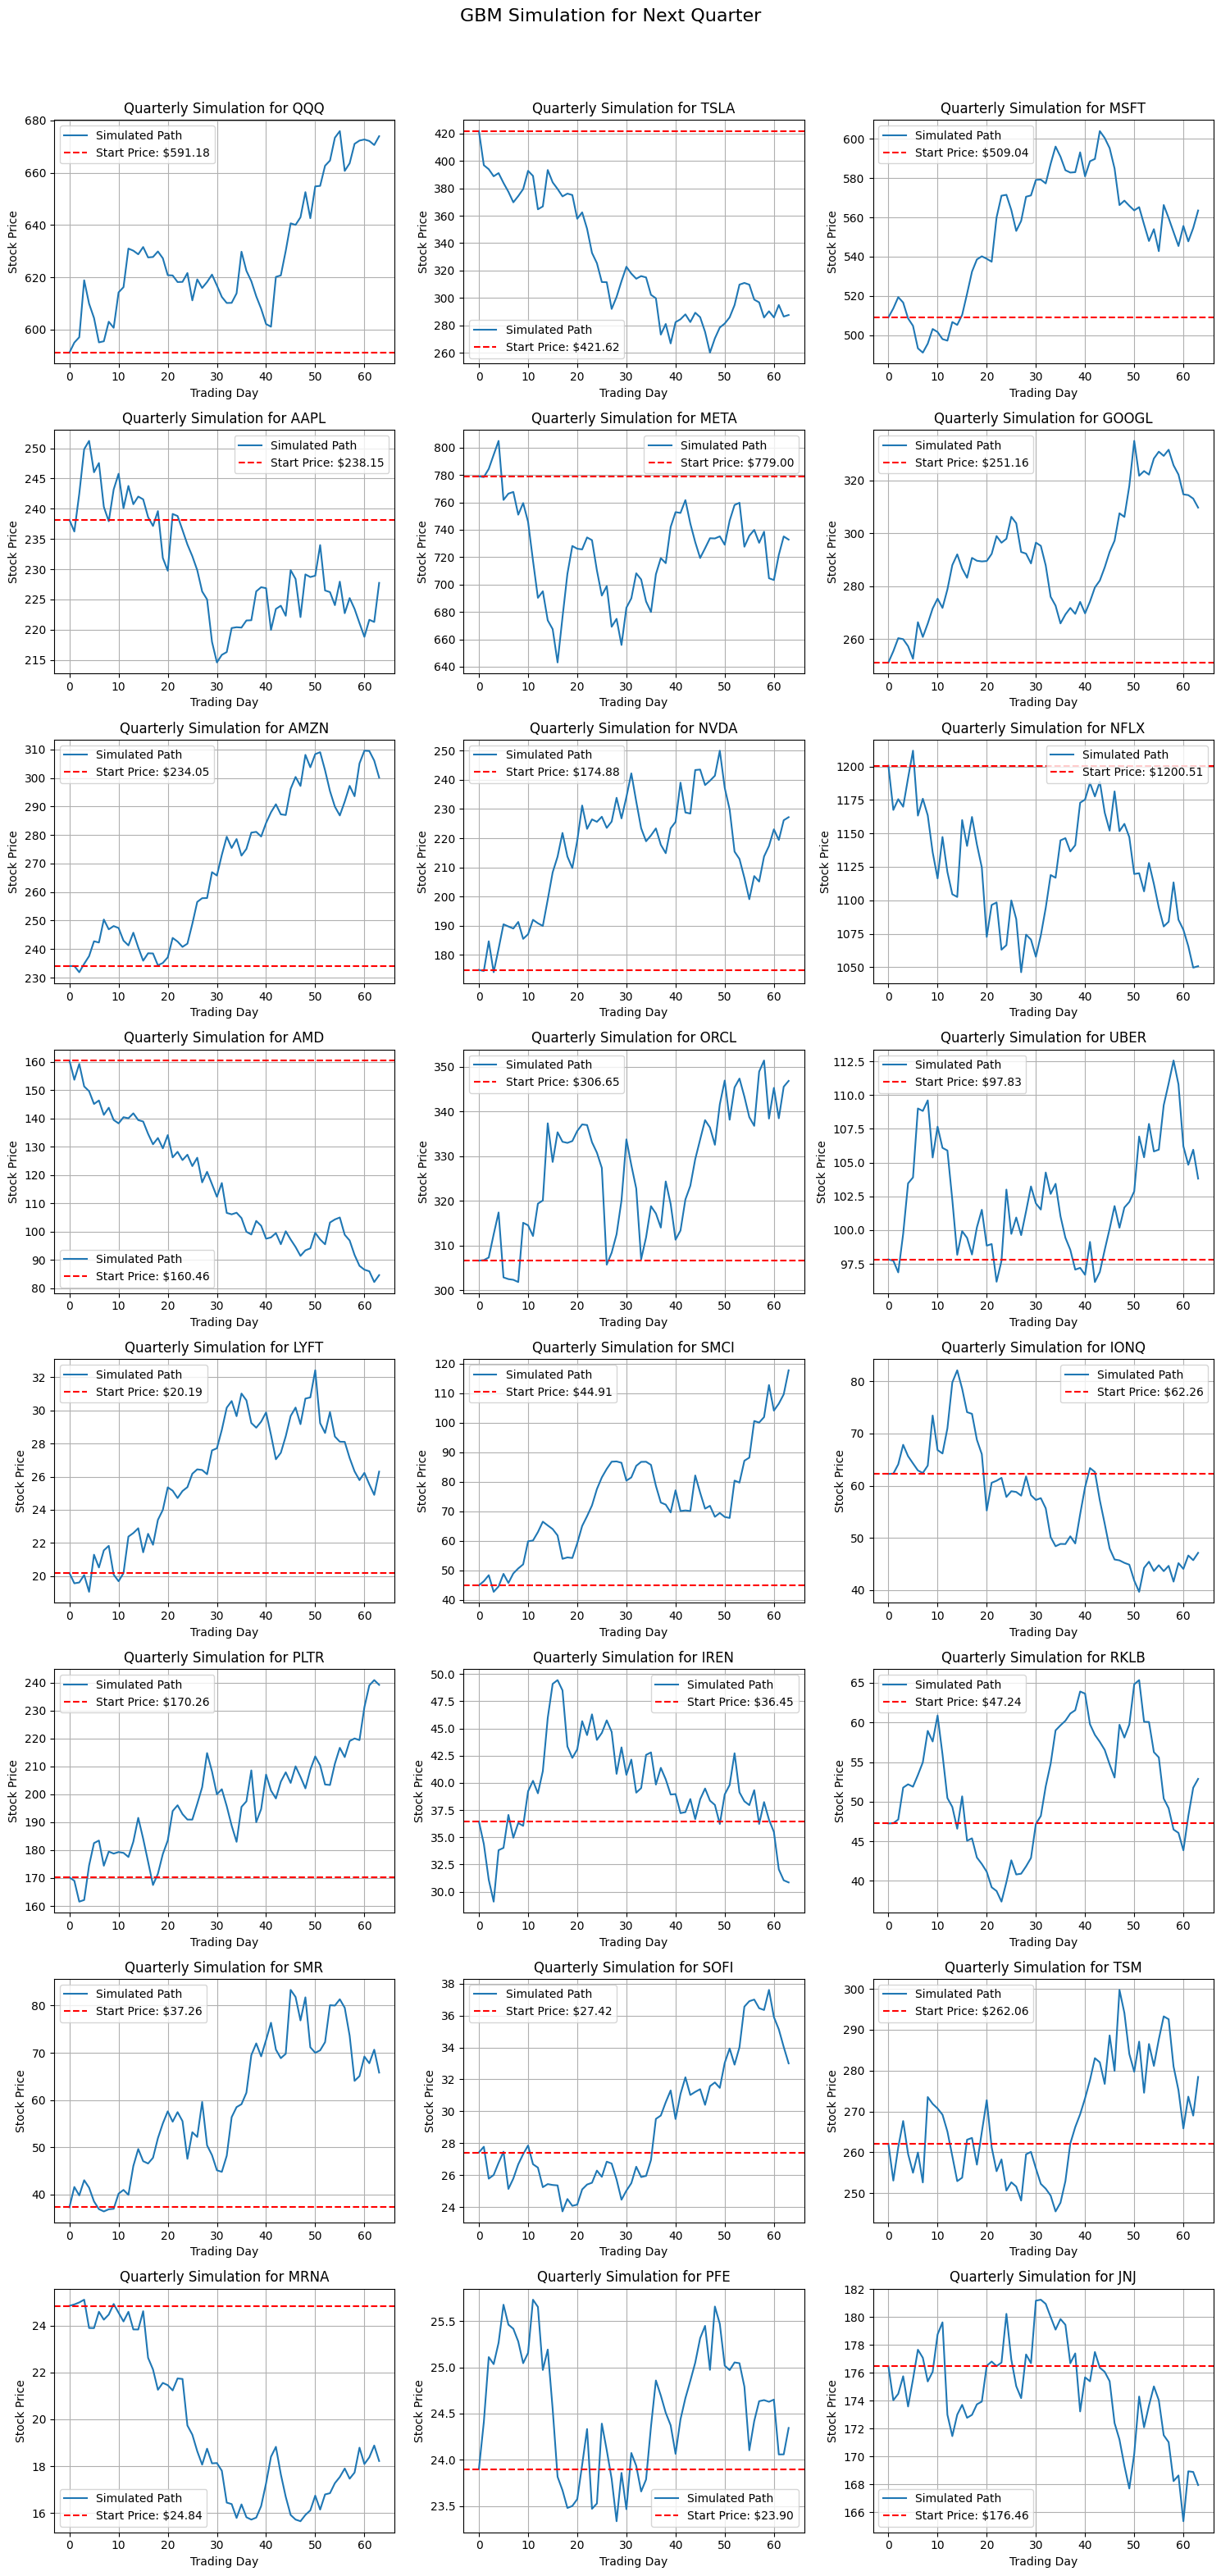

In [7]:
if __name__ == '__main__':
    tickers_to_plot = ["QQQ", "TSLA", "MSFT", "AAPL", "META", "GOOGL", "AMZN", "NVDA", "NFLX", "AMD", "ORCL", "UBER", 
                       "LYFT", "SMCI", "IONQ", "PLTR", "IREN", "RKLB", "SMR", "SOFI", "TSM", "MRNA", "PFE", "JNJ"]
    ranked_stocks = rank_stocks_by_gbm(tickers_to_plot, mode='quarterly')

    plot_gbm_simulations(tickers_to_plot, mode='quarterly')    


Ranking stocks based on hourly GBM simulation: 
Rank 1: IREN   | Score: 0.0580
Rank 2: TSLA   | Score: 0.0194
Rank 3: IONQ   | Score: 0.0186
Rank 4: AMD    | Score: 0.0142
Rank 5: SOFI   | Score: 0.0083
Rank 6: SMCI   | Score: 0.0072
Rank 7: NVDA   | Score: 0.0053
Rank 8: MRNA   | Score: 0.0043
Rank 9: META   | Score: 0.0029
Rank 10: QQQ    | Score: 0.0025
Rank 11: AMZN   | Score: 0.0004
Rank 12: TSM    | Score: -0.0010
Rank 13: NFLX   | Score: -0.0018
Rank 14: ORCL   | Score: -0.0018
Rank 15: MSFT   | Score: -0.0032
Rank 16: PFE    | Score: -0.0046
Rank 17: JNJ    | Score: -0.0061
Rank 18: LYFT   | Score: -0.0064
Rank 19: AAPL   | Score: -0.0066
Rank 20: GOOGL  | Score: -0.0098
Rank 21: UBER   | Score: -0.0132
Rank 22: SMR    | Score: -0.0183
Rank 23: PLTR   | Score: -0.0184
Rank 24: RKLB   | Score: -0.0600
Target tickers for hourly analysis: ['QQQ', 'TSLA', 'MSFT', 'AAPL', 'META', 'GOOGL', 'AMZN', 'NVDA', 'NFLX', 'AMD', 'ORCL', 'UBER', 'LYFT', 'SMCI', 'IONQ', 'PLTR', 'IREN', 'RKLB',

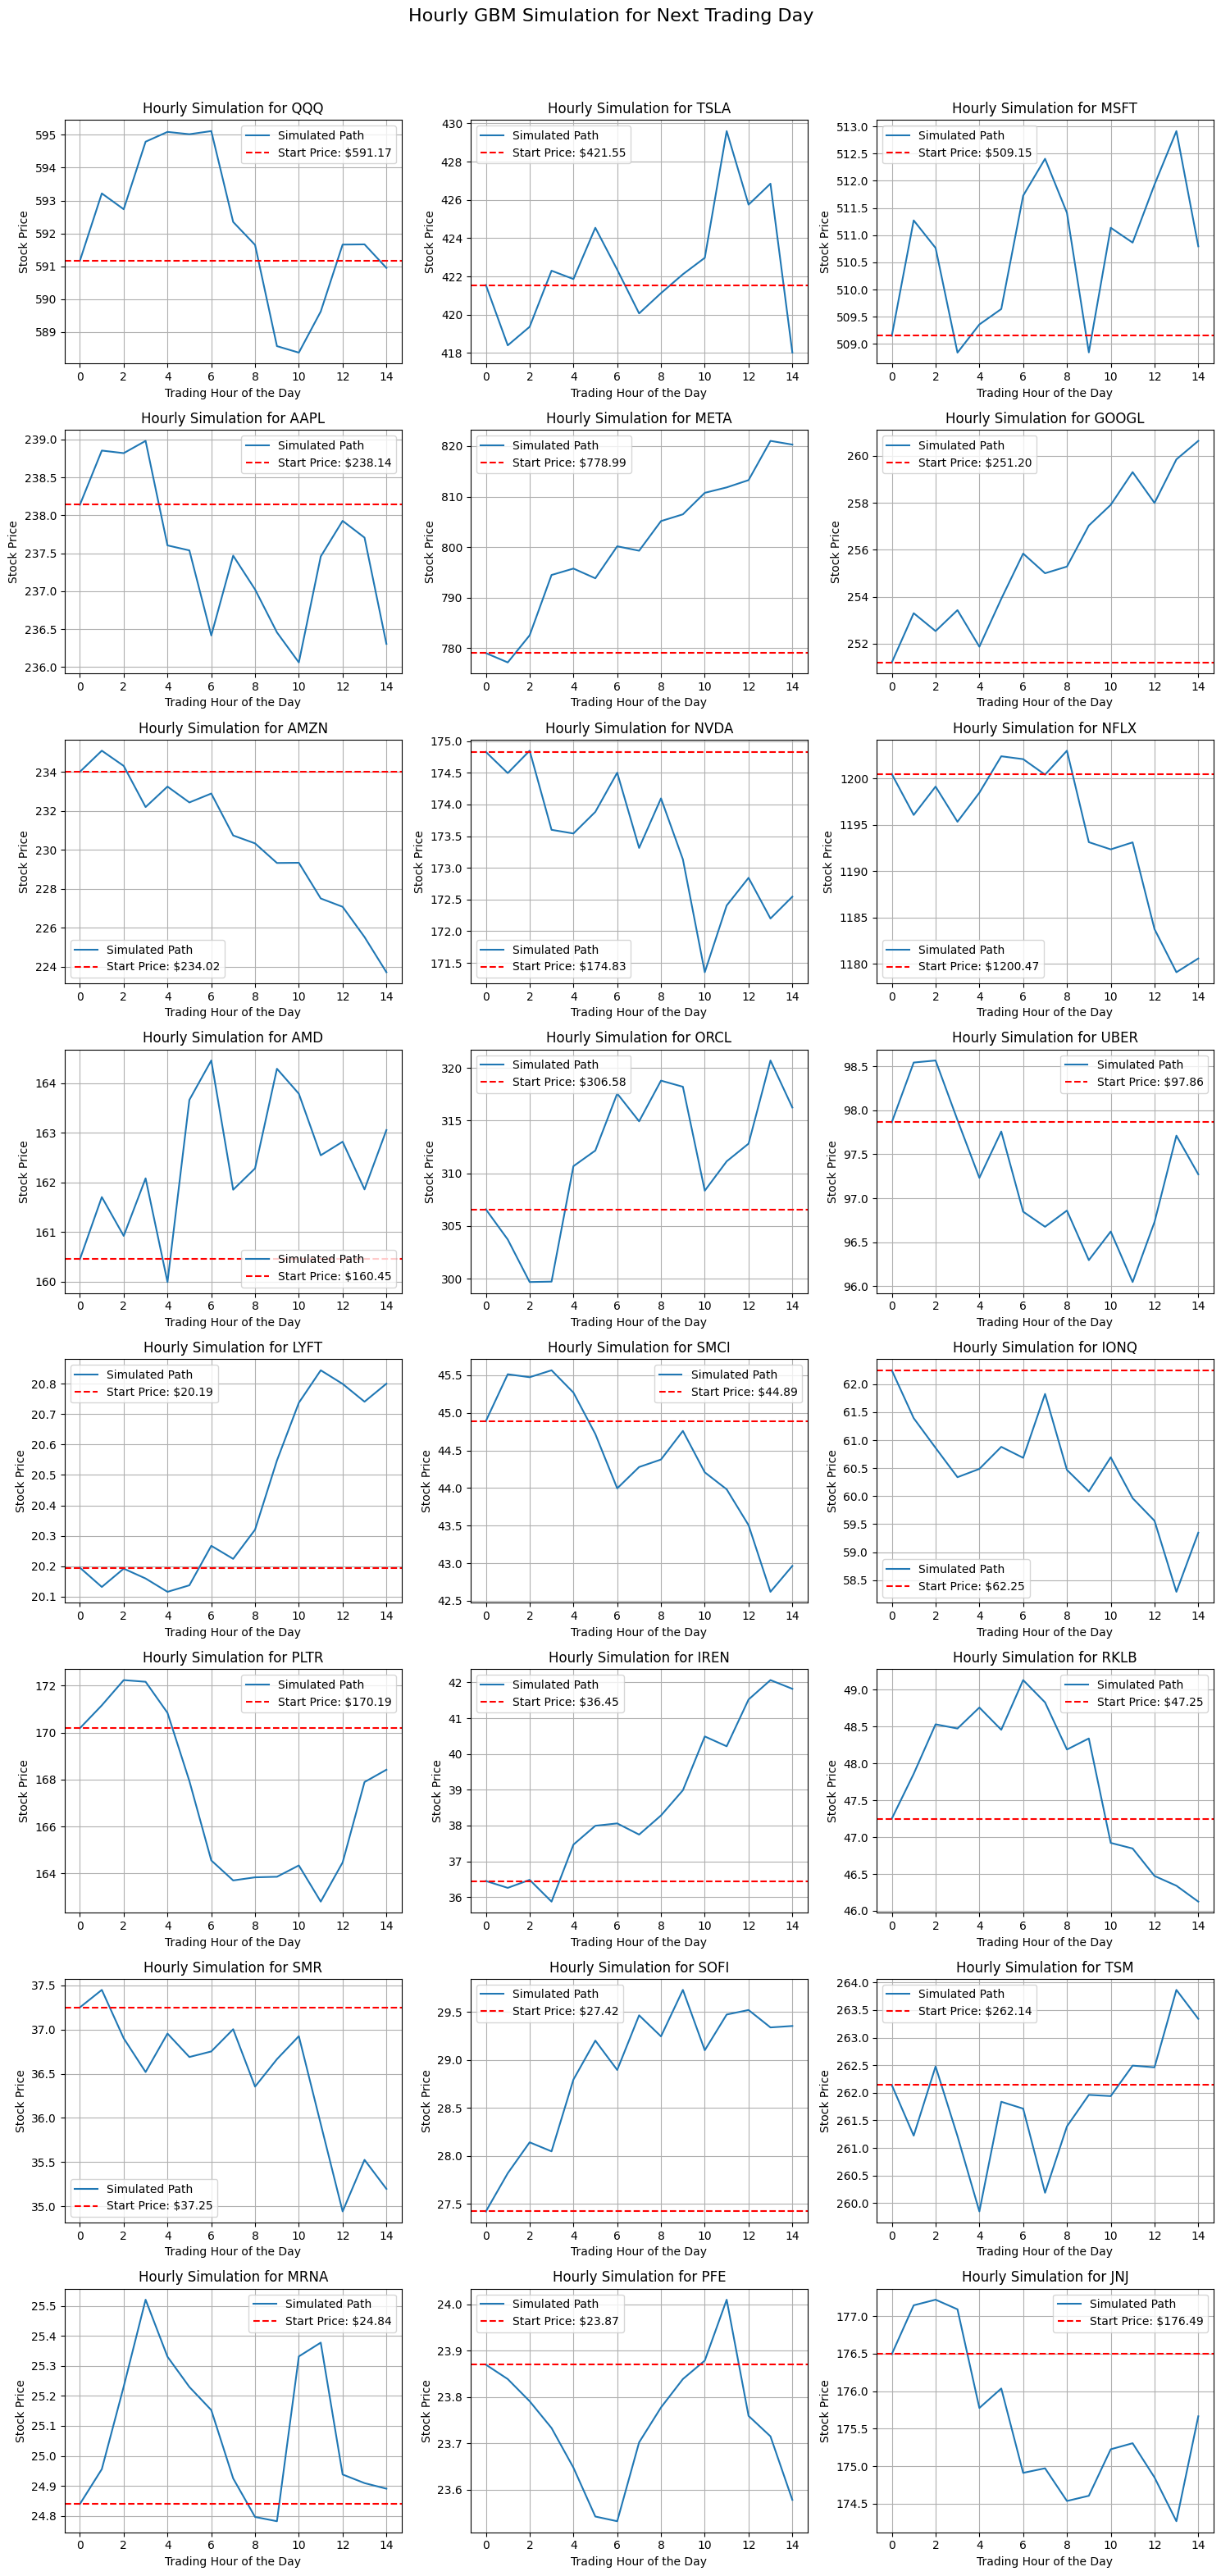

In [8]:
if __name__ == '__main__':
    tickers_to_plot = ["QQQ", "TSLA", "MSFT", "AAPL", "META", "GOOGL", "AMZN", "NVDA", "NFLX", "AMD", "ORCL", "UBER", 
                       "LYFT", "SMCI", "IONQ", "PLTR", "IREN", "RKLB", "SMR", "SOFI", "TSM", "MRNA", "PFE", "JNJ"]
    ranked_stocks = rank_stocks_by_gbm(tickers_to_plot, mode='hourly')

    plot_gbm_simulations(tickers_to_plot, mode='hourly')

### Code Workflow

1. **Download** 1-year daily close prices from Yahoo Finance using `yfinance` for each ticker.
2. **Calculate daily log returns**:
   $$
   Log Return = r_t = \log \left( \frac{P_t}{P_{t-1}} \right)
   $$
3. **Calculate daily drift** for each ticker using:
   $$
   drift = \mu - \frac{1}{2}\sigma^2
   $$
   where:
   - $\mu$ is the average daily log return
   - $\sigma$ is the standard deviation of daily log returns
4. **Store drift values** for each ticker in a dictionary.
5. **Convert drift values to percentages** for interpretability.
6. **Plot bar chart** comparing the drifts of QQQ, MSFT, AAPL, META, GOOGL, and TSLA:
   - **Blue bars** indicate positive drift (average upward trend)  
   - **Red bars** indicate negative drift (average downward trend)


### Key Observations

- **META** shows the highest positive drift (~0.1268%), suggesting a stronger average daily upward trend among the group.  
- **AAPL** and **GOOGL** showed slight negative drifts, indicating minor daily downward trends.  
- **TSLA** also shows a relatively strong positive drift (~0.0587%), reflecting its higher average daily growth rate.

### GBM Drift Bar Plot
The bar plot above visualizes:

- **Average daily drift (%)** for each stock over the past year  
- Stocks with **positive drift** potentially indicating expected upward price movement under GBM assumptions  
- Stocks with **negative drift** suggesting an average decline in daily log returns



In [9]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.ticker as mticker
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_gbm_drift(ticker_symbol):
    # Download past 1-year data
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    stock = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1d", progress=False)

    # Calculate log returns
    stock['LogReturn'] = np.log(stock['Close'] / stock['Close'].shift(1))
    stock = stock.dropna()

    # Calculate daily mu and sigma
    mu = stock['LogReturn'].mean()
    sigma = stock['LogReturn'].std()

    # Calculate average daily drift
    gbm_drift = mu - (0.5 * sigma**2)
    return gbm_drift

def plot_gbm_drift():
    # Specify list of tickers to analyze
    tickers_to_compare = ["QQQ", "TSLA", "MSFT", "AAPL", "META", "GOOGL", "AMZN", "NVDA", "NFLX", "AMD", "ORCL", "UBER", 
                       "LYFT", "SMCI", "IONQ", "PLTR", "IREN", "RKLB", "SMR", "SOFI", "TSM", "MRNA", "PFE", "JNJ"]
    drift_results = {}

    # Calculate drift for each ticker
    for ticker in tickers_to_compare:
        drift = get_gbm_drift(ticker)
        if drift is not None:
            drift_results[ticker] = drift

    if not drift_results:
        print("No drift values calculated. Cannot plot the chart.")
        return

    ticker_names = list(drift_results.keys())
    drift_percentages = [val * 100 for val in drift_results.values()]
    colors = ['royalblue' if val >= 0 else 'crimson' for val in drift_percentages]

    plt.figure(figsize=(20, 8))
    bars = plt.bar(ticker_names, drift_percentages, color=colors)

    plt.title('GBM Drift Comparison', fontsize=16)
    plt.ylabel('Average Daily Drift (%)', fontsize=12)
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
    plt.xticks(rotation=90, fontsize=9)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}%', 
                 va='bottom' if yval >=0 else 'top', ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

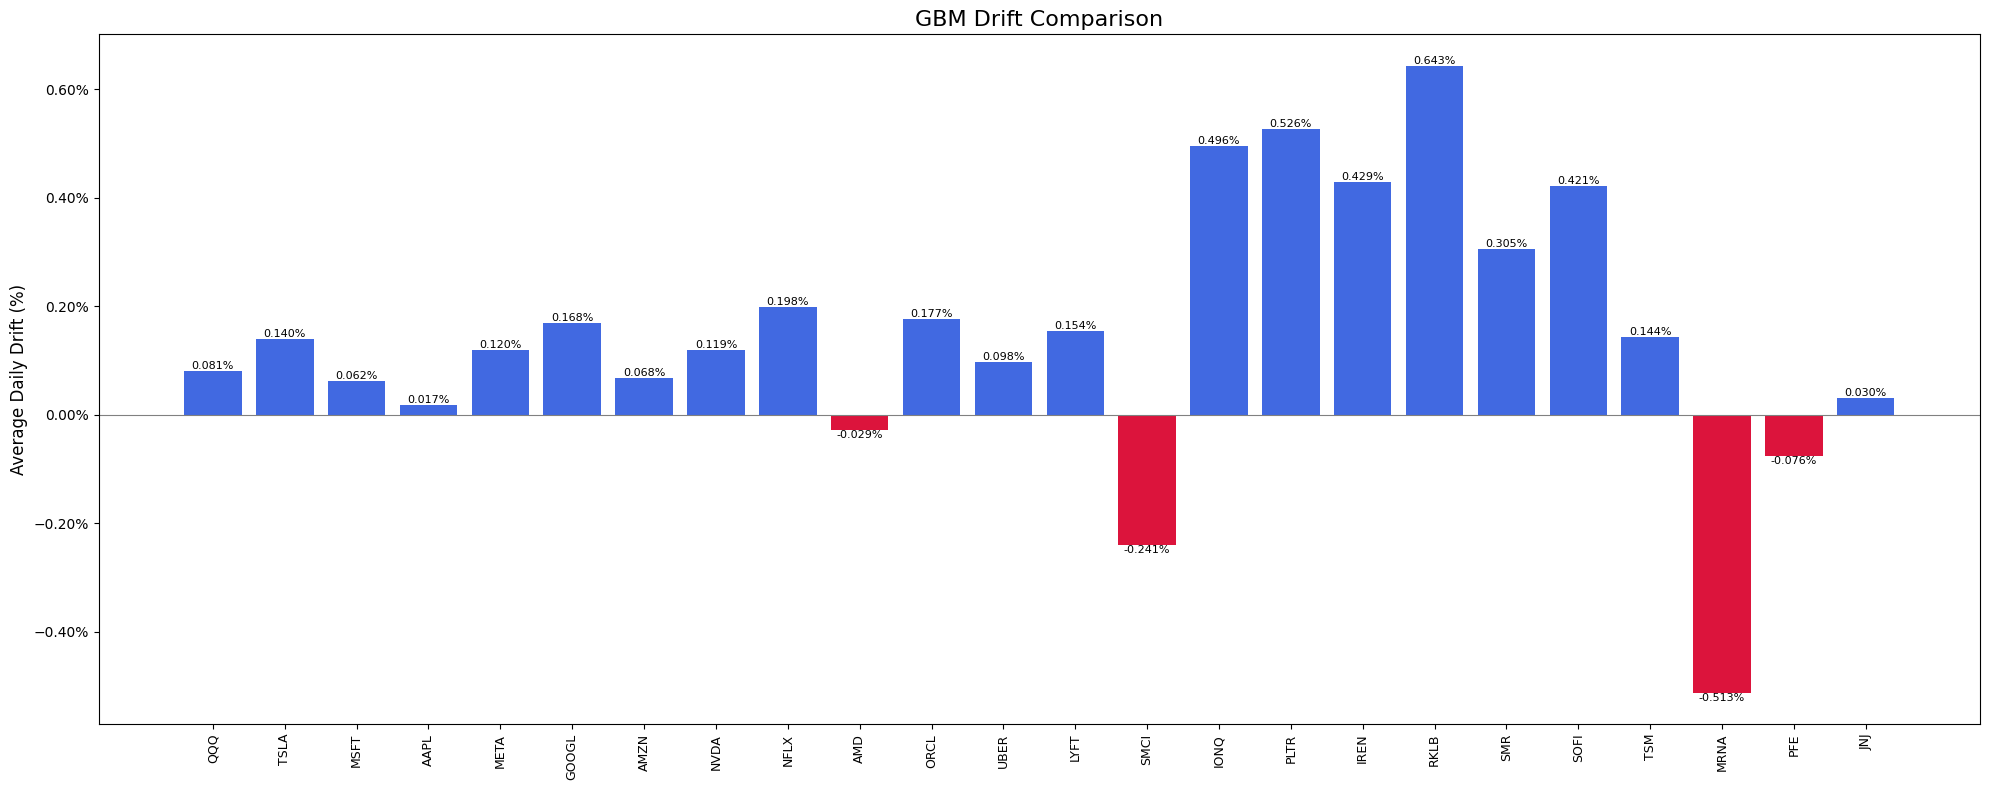

In [10]:
if __name__ == '__main__':
    plot_gbm_drift()